# XGBoost Forecasting & Accuracy Analysis
## Objectives
1.  **Refined Accuracy**: Use Gradient Boosting (`XGBRegressor`) for better performance.
2.  **Transparency**: Show Learning Curves and Actual vs Predicted graphs.
3.  **Extended Forecast Viz**: Compare Dec 25-Jan 7 and Dec 15-Jan 15 windows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder

# 1. Load & Resample Data (Daily)
df = pd.read_csv('shipment_booking_data_2021_2025.csv')
df['booking_date'] = pd.to_datetime(df['booking_date'])

df_daily = df.set_index('booking_date').groupby([
    'company_name', 
    pd.Grouper(freq='D')
])['shipment_type'].value_counts().unstack(fill_value=0).reset_index()

df_daily.columns.name = None
print("Data Loaded. Shape:", df_daily.shape)

Data Loaded. Shape: (14607, 6)


## Feature Engineering

In [2]:
df_daily = df_daily.sort_values(['company_name', 'booking_date']).reset_index(drop=True)
target_cols = ['Air', 'Express', 'International', 'Surface']
feat_cols = []

# Ensure columns
for col in target_cols:
    if col not in df_daily.columns: df_daily[col] = 0

# Targets (Next Day)
for col in target_cols:
    df_daily[f'target_{col}'] = df_daily.groupby('company_name')[col].shift(-1)

# Lags & Rolling
for col in target_cols:
    # Lag 1
    df_daily[f'lag_1_{col}'] = df_daily.groupby('company_name')[col].shift(0)
    feat_cols.append(f'lag_1_{col}')
    # Lag 7 (Weekly Seasonality)
    df_daily[f'lag_7_{col}'] = df_daily.groupby('company_name')[col].shift(6)
    feat_cols.append(f'lag_7_{col}')
    # Roll 7 (Trend)
    df_daily[f'roll_7_{col}'] = df_daily.groupby('company_name')[col].transform(lambda x: x.rolling(7, min_periods=1).mean())
    feat_cols.append(f'roll_7_{col}')

# Calendar
df_daily['day_of_week'] = df_daily['booking_date'].dt.dayofweek
df_daily['day'] = df_daily['booking_date'].dt.day
df_daily['month'] = df_daily['booking_date'].dt.month
feat_cols.extend(['day_of_week', 'day', 'month'])

# Encoding
le = LabelEncoder()
df_daily['company_encoded'] = le.fit_transform(df_daily['company_name'])
feat_cols.append('company_encoded')

df_clean = df_daily.dropna().copy()

## 1. XGBoost Training with Learning Curves

Training XGBoost for Air...


Training XGBoost for Express...


Training XGBoost for International...


Training XGBoost for Surface...


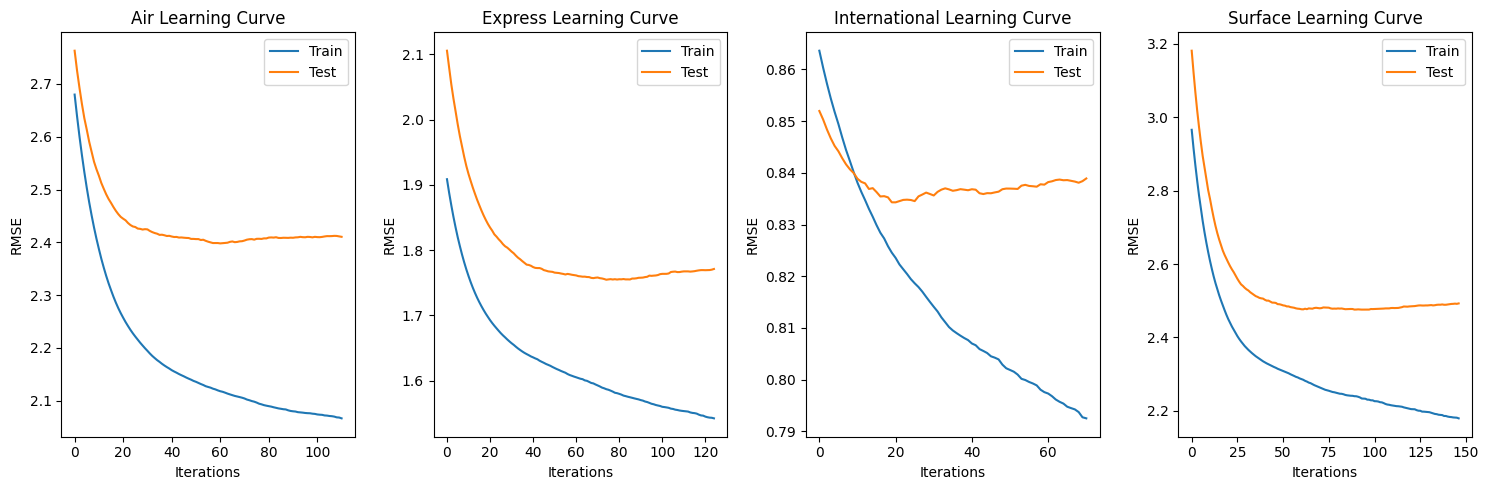

In [3]:
# Split for Validation (Cutoff: Nov 1, 2025)
split_date = '2025-11-01'
train_df = df_clean[df_clean['booking_date'] < split_date]
test_df = df_clean[df_clean['booking_date'] >= split_date]

models = {}
evals_results = {}

plt.figure(figsize=(15, 5))

for i, target in enumerate(target_cols):
    print(f"Training XGBoost for {target}...")
    X_train = train_df[feat_cols]
    y_train = train_df[f'target_{target}']
    X_test = test_df[feat_cols]
    y_test = test_df[f'target_{target}']
    
    model = XGBRegressor(
        n_estimators=500, 
        learning_rate=0.05, 
        max_depth=6,
        early_stopping_rounds=50,
        random_state=42
    )
    
    model.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    
    models[target] = model
    
    # Plot Learning Curve
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    
    plt.subplot(1, 4, i+1)
    plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
    plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
    plt.legend()
    plt.title(f'{target} Learning Curve')
    plt.ylabel('RMSE')
    plt.xlabel('Iterations')

plt.tight_layout()
plt.show()

## 2. Accuracy Visualization (Test Set: Nov-Dec 2025)

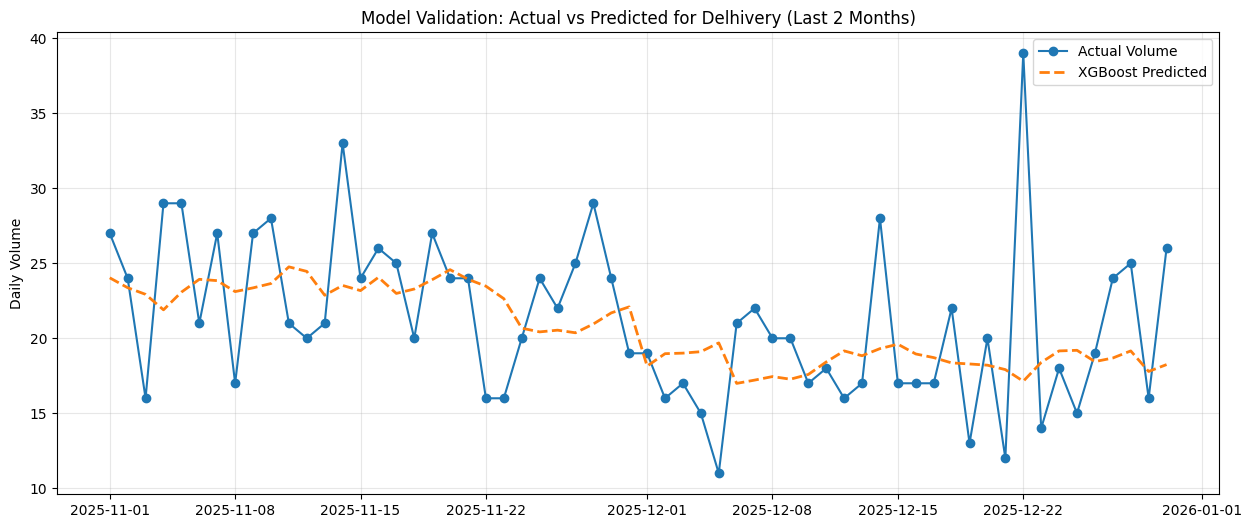

In [4]:
# Filter for Top Company (Delhivery) to make plot readable
company = 'Delhivery'
test_comp = test_df[test_df['company_name'] == company].copy()

plt.figure(figsize=(15, 6))

# Calculate Total Volume Predictions
test_comp['Pred_Total'] = 0
test_comp['Actual_Total'] = 0

for target in target_cols:
    pred = models[target].predict(test_comp[feat_cols])
    test_comp[f'Pred_{target}'] = np.maximum(0, pred)
    test_comp['Pred_Total'] += test_comp[f'Pred_{target}']
    test_comp['Actual_Total'] += test_comp[f'target_{target}']

plt.plot(test_comp['booking_date'], test_comp['Actual_Total'], label='Actual Volume', marker='o')
plt.plot(test_comp['booking_date'], test_comp['Pred_Total'], label='XGBoost Predicted', linestyle='--', linewidth=2)

plt.title(f"Model Validation: Actual vs Predicted for {company} (Last 2 Months)")
plt.ylabel("Daily Volume")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Recursive Forecasting (Next 7 Days)

In [5]:
# Re-train on FULL data (Train + Test) for final future forecast
full_models = {}
for target in target_cols:
    final_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
    final_model.fit(df_clean[feat_cols], df_clean[f'target_{target}'])
    full_models[target] = final_model

# Recursive Loop
last_days = df_clean.sort_values('booking_date').groupby('company_name').tail(1).copy()
current_state = last_days.copy()
future_preds = []

for i in range(7):
    next_date = current_state['booking_date'] + pd.Timedelta(days=1)
    current_state['booking_date'] = next_date
    current_state['day_of_week'] = next_date.dt.dayofweek
    current_state['day'] = next_date.dt.day
    current_state['month'] = next_date.dt.month
    
    step_res = {'Company': current_state['company_name'], 'Date': next_date}
    
    for target in target_cols:
        pred = full_models[target].predict(current_state[feat_cols])
        pred = np.maximum(0, np.round(pred)).astype(int)
        step_res[target] = pred
        # Update Lag 1 for next step
        current_state[f'lag_1_{target}'] = pred
        
    future_preds.append(pd.DataFrame(step_res))

final_schedule = pd.concat(future_preds, ignore_index=True)
final_schedule['Total_Vol'] = final_schedule[target_cols].sum(axis=1)

## 4. Forecast Visualizations (Requested Windows)

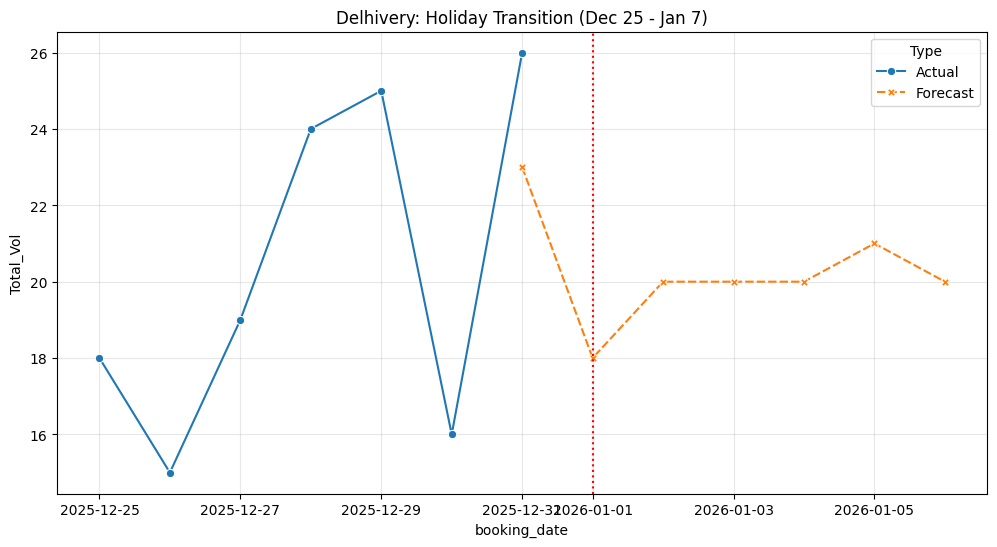

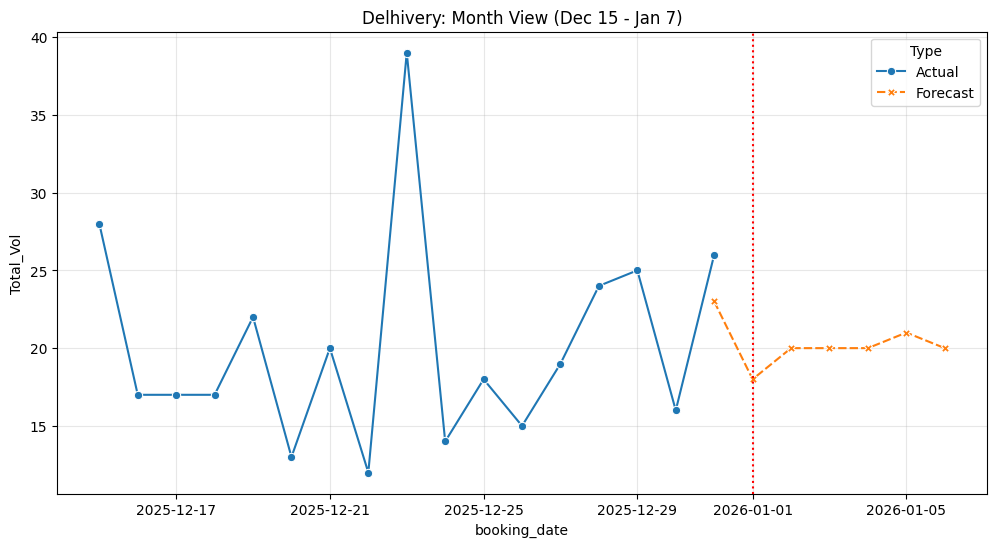

In [6]:
def plot_forecast_window(company, start_view_date, title_suffix):
    # 1. Get Historical Context
    hist = df_daily[df_daily['company_name'] == company].copy()
    hist['Total_Vol'] = hist[target_cols].sum(axis=1)
    hist = hist[hist['booking_date'] >= pd.Timestamp(start_view_date)]
    hist['Type'] = 'Actual'
    
    # 2. Get Forecast
    pred = final_schedule[final_schedule['Company'] == company].copy()
    pred = pred.rename(columns={'Date': 'booking_date'})
    pred['Type'] = 'Forecast'
    
    # 3. Combine
    combined = pd.concat([hist[['booking_date', 'Total_Vol', 'Type']], 
                          pred[['booking_date', 'Total_Vol', 'Type']]])
    
    # 4. Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=combined, x='booking_date', y='Total_Vol', hue='Type', style='Type', markers=True)
    
    # Add vertical line at transition (Jan 1)
    plt.axvline(pd.Timestamp("2026-01-01"), color='red', linestyle=':', label='Prediction Start')
    
    plt.title(f"{company}: {title_suffix}")
    plt.grid(True, alpha=0.3)
    plt.show()

# Viz 1: Dec 25 to Jan 7
plot_forecast_window('Delhivery', '2025-12-25', 'Holiday Transition (Dec 25 - Jan 7)')

# Viz 2: Dec 15 to Jan 15 (Forecasting out to Jan 7 only, but viewing from Dec 15)
plot_forecast_window('Delhivery', '2025-12-15', 'Month View (Dec 15 - Jan 7)')

Generating Holiday Window overlay for Delhivery...


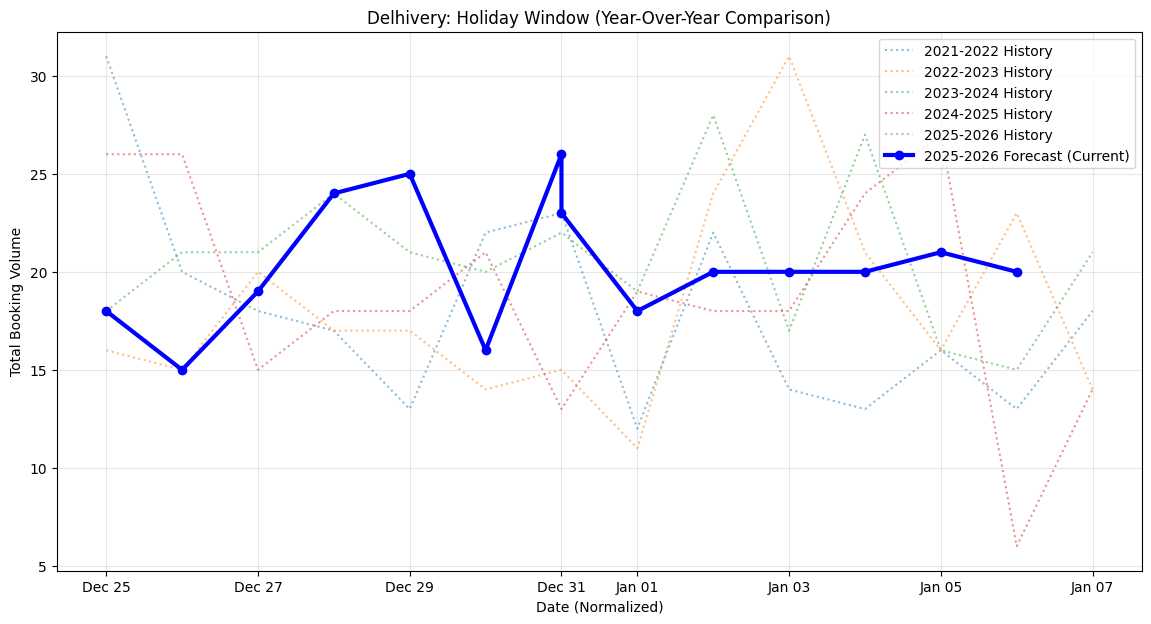

Generating Month Window overlay for Delhivery...


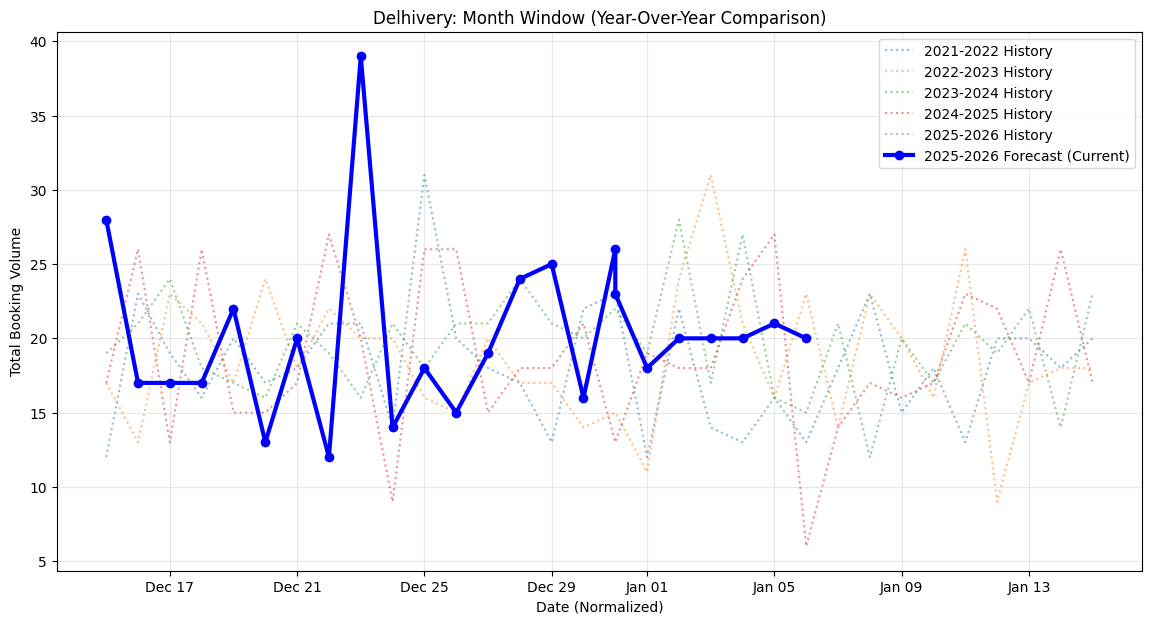

In [ ]:
# --- FINAL VISUALIZATION: Year-Over-Year Comparison (Overlay) ---

def plot_yoy_overlay(company_name, start_md, end_md, title_suffix):
    """
    Plots an overlay of multiple years for a specific Month-Day date range.
    Example: start_md=(12, 15), end_md=(1, 15) for Dec 15 - Jan 15.
    """
    print(f"Generating {title_suffix} overlay for {company_name}...")
    
    # 1. Prepare Data
    # Get History
    comp_hist = df_daily[df_daily['company_name'] == company_name].copy()
    comp_hist['Total_Vol'] = comp_hist[target_cols].sum(axis=1)
    
    # Get Forecast (2026 data)
    comp_pred = final_schedule[final_schedule['Company'] == company_name].copy()
    comp_pred['booking_date'] = pd.to_datetime(comp_pred['Date'])
    comp_pred['Total_Vol'] = comp_pred[target_cols].sum(axis=1)
    
    # 2. Define Date Normalizer (Map to Year 2000/2001)
    def get_plot_date(row):
        desc_month = row.month
        desc_day = row.day
        
        # Logic: If month is Dec (12), map to 2000. If Jan (1), map to 2001.
        # This creates a sorted X-axis spanning the new year.
        if desc_month == 12:
            return pd.Timestamp(f"2000-{desc_month}-{desc_day}")
        else:
            return pd.Timestamp(f"2001-{desc_month}-{desc_day}")
            
    plt.figure(figsize=(14, 7))
    
    # 3. Plot Historical Years (2021-2025)
    # We iterate distinct 'seasons'. A 'season' is defined by the Year of the Dec part.
    # e.g., Season 2021 = Dec 2021 to Jan 2022
    start_month, start_day = start_md
    end_month, end_day = end_md
    
    years = sorted(comp_hist['booking_date'].dt.year.unique())
    
    for year in range(2021, 2026):
        # Define the actual date dates for this year's season
        season_start = pd.Timestamp(f"{year}-{start_month}-{start_day}")
        season_end = pd.Timestamp(f"{year+1}-{end_month}-{end_day}")
        
        mask = (comp_hist['booking_date'] >= season_start) & (comp_hist['booking_date'] <= season_end)
        season_data = comp_hist[mask].copy()
        
        if not season_data.empty:
            season_data['plot_date'] = season_data['booking_date'].apply(get_plot_date)
            season_data = season_data.sort_values('plot_date')
            
            # Plot line
            plt.plot(season_data['plot_date'], season_data['Total_Vol'], 
                     linestyle=':', alpha=0.5, label=f'{year}-{year+1} History')

    # 4. Plot The FORECAST Season (2025-2026)
    # Composed of: Actuals (Dec 15 '25 - Dec 31 '25) + Forecast (Jan 1 '26 - Jan 7 '26)
    # Note: Forecast only goes to Jan 7. If end date > Jan 7, we just plot what we have.
    
    # A. Actual Part
    cur_season_start = pd.Timestamp(f"2025-{start_month}-{start_day}")
    cur_season_end_act = pd.Timestamp("2025-12-31")
    mask_act = (comp_hist['booking_date'] >= cur_season_start) & (comp_hist['booking_date'] <= cur_season_end_act)
    actual_part = comp_hist[mask_act].copy()
    actual_part['Type'] = 'Actual'
    
    # B. Forecast Part
    # Forecast df is Jan 1 - Jan 7
    forecast_part = comp_pred.copy()
    forecast_part = forecast_part[['booking_date', 'Total_Vol']].copy()
    forecast_part['Type'] = 'Forecast'
    
    # Combine
    full_season = pd.concat([actual_part[['booking_date', 'Total_Vol', 'Type']], 
                             forecast_part[['booking_date', 'Total_Vol', 'Type']]])
    
    # Normalize Dates
    full_season['plot_date'] = full_season['booking_date'].apply(get_plot_date)
    full_season = full_season.sort_values('plot_date')
    
    # Plot predictions
    plt.plot(full_season['plot_date'], full_season['Total_Vol'], 
             color='blue', linewidth=3, marker='o', label='2025-2026 Forecast (Current)')
    
    # Formatting
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.title(f"{company_name}: {title_suffix} (Year-Over-Year Comparison)")
    plt.ylabel("Total Booking Volume")
    plt.xlabel("Date (Normalized)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

# --- EXECUTE PLOTS ---
# 1. Holiday Window (Dec 25 - Jan 7)
plot_yoy_overlay('Delhivery', start_md=(12, 25), end_md=(1, 7), title_suffix="Holiday Window")
# 2. Month Context (Dec 15 - Jan 15)
# Note: Forecast line will stop at Jan 7 (as we only predicted 7 days), but history will show full context.
plot_yoy_overlay('Delhivery', start_md=(12, 15), end_md=(1, 15), title_suffix="Month Window")